In [1]:
import pandas as pd
import numpy as np

# read Excel file
input_file_path = 'SampleData.csv.csv'
dfTotal = pd.read_csv(input_file_path,sep=",|:|;",engine="python",header=0)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd0 in position 0: invalid continuation byte

In [2]:
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_origin = dfTotal.iloc[:, 2:-1]  # The feature starts in the third column, excluding the last column

scaler = StandardScaler() # Data Standlization
X = scaler.fit_transform(X_origin)

# Professional comprehensive value is classified label, less than 70 points and not less than 70 points are the 2 classes
Value = dfTotal.iloc[:, -1]
y = np.array([1 if x >= 70 else 0 for x in Value])

n_features = X.shape[1]

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

def calculate_neighborhood(X, radius):
    """
    Calculate the neighborhood within a given radius.
    """
    distances = euclidean_distances(X, X)
    neighborhoods = distances <= radius
    return neighborhoods

def dependency(X, y, neighborhoods):
    """
    Calculate the degree of dependence for a given neighborhood.
    """
    n_samples = X.shape[0]
    positive_region = 0
    for i in range(n_samples):
        neighborhood_indices = np.where(neighborhoods[i])[0]
        if all(y[i] == y[j] for j in neighborhood_indices):
            positive_region += 1
    res = positive_region / n_samples
    return res

def feature_importance(X, y, current_features, candidate_feature, radius):
    """
    Calculate the importance of candidate features.
    """
    if not current_features:  # If there are currently no features, the dependence of the candidate features is calculated directly
        neighborhoods = calculate_neighborhood(X[:, [candidate_feature]], radius)
        return dependency(X[:, [candidate_feature]], y, neighborhoods)
    else:
        combined_features = current_features + [candidate_feature]
        neighborhoods = calculate_neighborhood(X[:, combined_features], radius)
        return dependency(X[:, combined_features], y, neighborhoods) - dependency(X[:, current_features], y, calculate_neighborhood(X[:, current_features], radius))

def neighborhood_rough_set_feature_selection(X, y, importance_threshold, radius):
    """
    Attribute reduction for neighborhood rough sets by forward greedy algorithm.
    """
    n_features = X.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))
    current_importance = 0

    while remaining_features:
        best_feature = None
        best_importance_increase = 0
        for feature in remaining_features:
            importance_increase = feature_importance(X, y, selected_features, feature, radius)
            if importance_increase > best_importance_increase:
                best_importance_increase = importance_increase
                best_feature = feature

        if best_importance_increase > importance_threshold:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            current_importance += best_importance_increase
        else:
            break

    return selected_features
    


In [4]:
# svm_classifier.py

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

def svm_cross_validation(X, y):
    """
    Classification was performed using a support vector machine (SVM) and ten fold cross-validation was performed to assess accuracy.

    Parameters:
    X -- attribute data set (number of samples x number of attributes)
    y -- Array of class tags

    Return:
    mean_accuracy - Average accuracy of 10% cross validation
    """
    # Initialize the SVM classifier, with default RBF kernel
    svm_classifier = SVC(kernel='rbf', gamma='scale')
    
    # Perform 10-fold cross-validation
    accuracies = cross_val_score(svm_classifier, X, y, cv=10)
    
    # Calculate average accuracy
    mean_accuracy = np.mean(accuracies)
    
    return mean_accuracy


In [5]:
def evaluate_parameter_combinations(X, y, importance_thresholds, radius_range, radius_step):
    """
    Different importance limits and neighborhood radius harmonic parameter combinations are evaluated.

    Parameters:
    X -- attribute data set (number of samples x number of attributes)
    y -- Array of class tags
    importance_thresholds - List of importance thresholds
    radius_range - Range of neighborhood radius (start, end)
    radius_step - Step size of neighborhood radius

    Return:
    results - A list containing the average accuracy for each combination of parameters
    """
    results = []
    for threshold in importance_thresholds:
        for radius in np.arange(radius_range[0], radius_range[1], radius_step):
            # Perform attribute reduction
            selected_features = neighborhood_rough_set_feature_selection(X, y, threshold, radius)
            accuracy = 0
            if selected_features:  # 如果没有选出任何特征，跳过
                # 使用选出的特征进行SVM分类并进行十折交叉验证
                X_reduced = X[:, selected_features]
                accuracy = svm_cross_validation(X_reduced, y)
            result = (threshold, radius, accuracy, selected_features)
            print(result)
            results.append(result)
            
    return results


In [ ]:
# 设置重要度下限和邻域半径范围
importance_thresholds = [0.01, 0.001]
radius_range = (2, 4)
radius_step = 0.2

# 评估参数组合
results = evaluate_parameter_combinations(X, y, importance_thresholds, radius_range, radius_step)


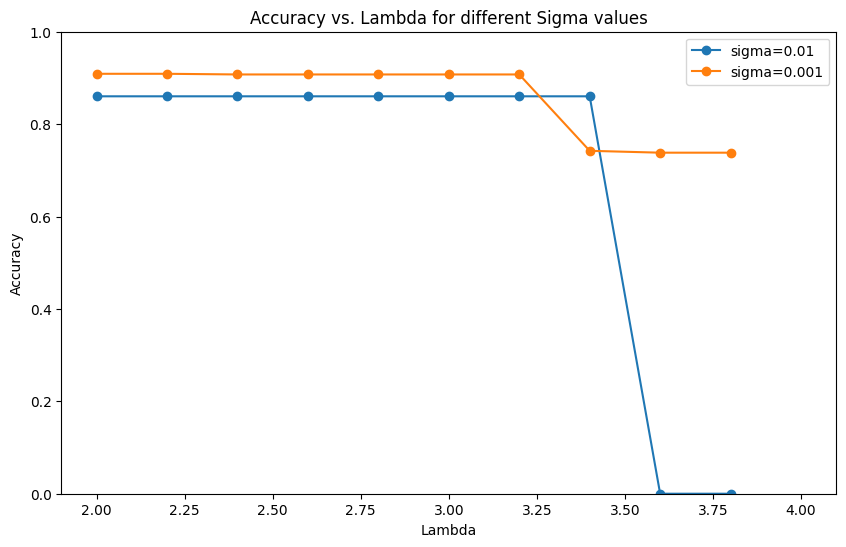

In [7]:
df = pd.DataFrame(results, columns=['sigma', 'lambda', 'accuracy', 'selected_features'])
# 创建一个空的DataFrame来存储结果
unique_sigmas = df['sigma'].unique()
unique_lambdas = sorted(df['lambda'].unique())
result_df = pd.DataFrame(index=unique_sigmas, columns=unique_lambdas)

# 填充结果DataFrame
for _, row in df.iterrows():
    sigma, lambda_, _, selected_features = row
    # 假设X是你的原始DataFrame，包含所有特征
    # feature_names = X.columns[2:][selected_features]  # 从第三列开始的列标题
    # 这里我们直接使用selected_features作为示例
    result_df.at[sigma, lambda_] = ', '.join(map(str, selected_features))

import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(10, 6))

# 对于每个唯一的sigma值，绘制一条折线
for sigma in unique_sigmas:
    subset = df[df['sigma'] == sigma]
    plt.plot(subset['lambda'], subset['accuracy'], marker='o', label=f'sigma={sigma}')

plt.xlabel('Lambda')
plt.ylabel('Accuracy')
# 设置x轴和y轴的显示区间
plt.xlim([1.9, 4.1])
plt.ylim([0, 1])
plt.title('Accuracy vs. Lambda for different Sigma values')
plt.legend()
plt.grid(False)
plt.show()


In [8]:
# 结果
import csv

# 指定CSV文件名
filename = 'results.csv'

# 打开文件准备写入
with open(filename, 'w', newline='') as file:
    # 创建CSV写入器
    writer = csv.writer(file)
    
    # （可选）写入标题行
    writer.writerow(['Threshold', 'Radius', 'Accuracy', 'Selected Features'])
    
    # 遍历results，写入数据行
    for result in results:
        threshold, radius, accuracy, selected_features = result
        # 将selected_features数组转换为字符串，元素之间用逗号分隔
        if len(selected_features)>0:
            selected_features_str = ';'.join([str(feature + 3) for feature in selected_features]) # 记得第三列开始是特征列，因此第0个索引=第3列。
        else:
            selected_features_str = 'NA'
        # 写入当前行
        writer.writerow([threshold, radius, accuracy, selected_features_str])
